In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os 
import sys
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict 


In [2]:
WINDOW_SIZE = 25

In [3]:
#TODO make supervised learning dataset from csv files
#TODO build dataloader
solar_data = np.genfromtxt('data\\training_data\\train_solar.csv', delimiter=',', skip_header=1)
wind_data = np.genfromtxt('data\\training_data\\train_wind.csv', delimiter=',',skip_header=1)


In [4]:
solar_data.shape, wind_data.shape

((17544, 11), (17544, 11))

In [5]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [ ]:
def move_sliding_window_24h(data, window_size, inputs_cols_indices, label_col_index, forecast_horizon=24):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    label_col_index: index of the label column in data
    forecast_horizon: number of time steps ahead to predict
    """

    # Calculate the number of instances based on the available data minus the window size and forecast horizon
    num_instances = len(data) - window_size - forecast_horizon + 1

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((num_instances, window_size, len(inputs_cols_indices)))
    labels = np.zeros(num_instances)

    for i in range(num_instances):
        inputs[i] = data[i:i + window_size, inputs_cols_indices]
        labels[i] = data[i + window_size + forecast_horizon - 1, label_col_index]  # Label is forecast_horizon steps ahead

    print(inputs.shape, labels.shape)

    return inputs, labels

In [6]:
solar_X, solar_y = move_sliding_window(solar_data, WINDOW_SIZE, range(11), 0)
wind_X, wind_y = move_sliding_window(wind_data, WINDOW_SIZE, range(11), 0)

(17519, 25, 11) (17519, 1)
(17519, 25, 11) (17519, 1)


In [58]:
#sliding window for predicitng 24 ahread instead of 1
solar_y_24 = np.roll(solar_y, -24) #shift 24 hours ahead


[[-0.89679607]
 [-0.90517156]
 [-0.91285846]
 [-0.91991477]
 [-0.92639337]
 [-0.93234255]
 [-0.93780638]
 [-0.94115568]
 [-0.93104768]
 [-0.90421752]]
[[-0.96459556]
 [-0.96776113]
 [-0.97061679]
 [-0.97319736]
 [-0.97553301]
 [-0.97765001]
 [-0.9795713 ]
 [-0.98025675]
 [-0.96751979]
 [-0.93005719]
 [-0.87482354]
 [-0.8187356 ]
 [-0.77384916]
 [-0.75200172]
 [-0.75831208]
 [-0.77751507]
 [-0.79586692]
 [-0.81266325]
 [-0.82804247]
 [-0.84212966]
 [-0.85503797]
 [-0.86686994]
 [-0.87771858]
 [-0.88766837]
 [-0.89679607]]


In [7]:
print(solar_X[0], '\n', solar_y[0])


[[-1.         -1.         -1.         -1.         -0.39492153  0.21077271
   0.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39191435  0.21077271
   1.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39321545  0.21077271
   2.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39499721  0.21077271
   3.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39659511  0.21077271
   4.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39866141  0.21077271
   5.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.40071957  0.21077271
   6.          1.          1.          1.          1.        ]
 [-1.         -0.99999988 -0.99999955 -1.

In [8]:
#create dataset
class SolarDataset(Dataset):
    def __init__(self, inputs, output):
        self.inputs = inputs
        self.output = output

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.output[idx]

solar_dataset = SolarDataset(solar_X, solar_y)
wind_dataset = SolarDataset(wind_X, wind_y)
dataloader_solar = DataLoader(solar_dataset, batch_size=32, shuffle=False, drop_last=True) 
dataloader_wind = DataLoader(wind_dataset, batch_size=32, shuffle=False, drop_last=True)  
  


In [9]:
solar_data_val = np.genfromtxt('data\\training_data\\val_solar.csv', delimiter=',', skip_header=1)
solar_X_val, solar_y_val = move_sliding_window(solar_data_val, WINDOW_SIZE, range(11), 0)
solar_dataset_val = SolarDataset(solar_X_val, solar_y_val)
dataloader_solar_val = DataLoader(solar_dataset_val, batch_size=32, shuffle=False, drop_last=True)

(8735, 25, 11) (8735, 1)


In [10]:
alpha = 2
N_h = solar_data.shape[0] / (alpha * (11 + 1))
print(N_h)

731.0


In [11]:
from GRU_model import GRUNet

INPUT_SIZE = solar_X.shape[2]
HIDDEN_SIZE = 16
NUM_LAYERS = 2
OUTPUT_SIZE = solar_y.shape[1]
DROP_PROB = .5
lr = 0.001

In [12]:
print(INPUT_SIZE, OUTPUT_SIZE)

11 1


In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
model

GRUNet(
  (gru): GRU(11, 16, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, grad_clip_param, apply_gradient_clipping=False):
    model.train()
    losses_train = []
    losses_val = [] 
    best_val_loss = np.inf
    best_epoch = 0
    eps = 1e-6
    
    for epoch in range(num_epochs):
        train_losses = []
        for i, (input, target) in enumerate(train_loader):
            
            
            input, target  = input.to(device), target.to(device)
        
            optimizer.zero_grad()
            
            h = model.init_hidden(input.size(0)).to(device)
            
            output, hidden = model(input.float(), h)

            loss = criterion(output, target.float())
            # gradient clipping
            loss.backward()
            if apply_gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_param)
            optimizer.step()
            
            train_losses.append(loss.item())

        # validate
        model.eval()
        val_losses = []
        with torch.no_grad():
            for i, (input, target) in enumerate(val_loader):
                input, target  = input.to(device), target.to(device)
                h = model.init_hidden(input.size(0)).to(device)
                output, hidden = model(input.float(), h)
                    
                val_loss = criterion(output, target.float())
                val_losses.append(val_loss.item())

        #print epoch results
        print(f'Epoch {epoch}, train loss: {np.mean(train_losses)}, val loss: {np.mean(val_losses)}')

                
        losses_train.append(np.mean(train_losses))
        losses_val.append(np.mean(val_losses))

    return model, losses_train, losses_val

In [23]:
N_EPOCHS = 100

grad_clip_param = 2

model, losses_train, losses_val = train_model(model, dataloader_solar, dataloader_solar_val,  criterion, optimizer, num_epochs=N_EPOCHS, apply_gradient_clipping=True, grad_clip_param=grad_clip_param)


Epoch 0, train loss: 0.08533979780500384, val loss: 0.2439885282799557
Epoch 1, train loss: 0.07134200486723143, val loss: 0.09237526652171202
Epoch 2, train loss: 0.05662171646939434, val loss: 0.08348656411673051
Epoch 3, train loss: 0.051743480532261556, val loss: 0.07250889696489835
Epoch 4, train loss: 0.046805613420642336, val loss: 0.19525775150053531
Epoch 5, train loss: 0.05268103304632788, val loss: 0.21655869341296186
Epoch 6, train loss: 0.04847570093007251, val loss: 0.2198562948334952
Epoch 7, train loss: 0.04137041941059539, val loss: 0.1909649561470467
Epoch 8, train loss: 0.04364348617335526, val loss: 0.18427647606564707
Epoch 9, train loss: 0.03912882147439018, val loss: 0.16032147365823382
Epoch 10, train loss: 0.035902572708064774, val loss: 0.19156538730642161
Epoch 11, train loss: 0.03339533959970838, val loss: 0.1944984880685618
Epoch 12, train loss: 0.03023722404699753, val loss: 0.06793199655315701
Epoch 13, train loss: 0.024273088131541765, val loss: 0.064163

In [25]:
torch.save(model.state_dict(), 'model_15_window_size.pth')

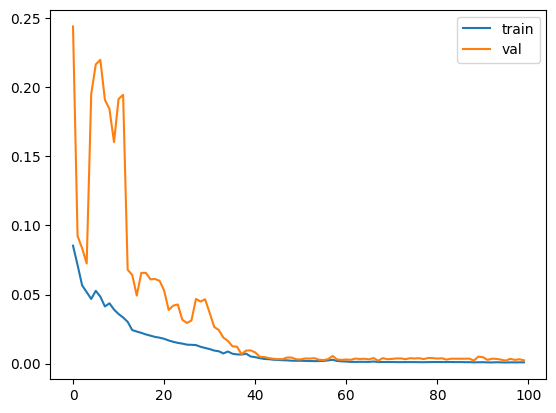

In [28]:
# plot losses
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.savefig('loss_15_window_size.png')
plt.show()



In [50]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [51]:
solar_X_combined = np.concatenate((solar_X, solar_X_val), axis=0)   
solar_y_combined = np.concatenate((solar_y, solar_y_val), axis=0)
train_indices = [-1] * len(solar_X)
val_indices = [0] * len(solar_X_val)
test_fold = np.array(train_indices + val_indices)
ps = PredefinedSplit(test_fold)


In [55]:


net = NeuralNetRegressor(
    module=GRUNet,
    module__input_dim=INPUT_SIZE,  # Set the input dimension
    module__output_dim=OUTPUT_SIZE,  # Set the output dimension
    criterion=torch.nn.MSELoss,
    optimizer=optim.Adam,
    device='cuda'  # Change this to 'cpu' if not using a GPU
)

params = {
    'module__hidden_dim': [16, 32, 64],
    'module__n_layers': [1, 2, 3],
    'module__drop_prob': [0.1, 0.2, 0.3],
    'optimizer__lr': [0.001, 0.01, 0.1],
    'optimizer__weight_decay': [0.0001, 0.001],
    'max_epochs': [10, 20, 50],
    'batch_size': [16, 32, 64],
    'iterator_train__shuffle': [False],  # Set shuffle to False for time series data
}

# Using predefined split as before
gs = GridSearchCV(net, params, refit=False, cv=ps, scoring='neg_mean_squared_error', verbose=2, error_score='raise')

# Fit the Grid Search with combined data
gs.fit(solar_X_combined, solar_y_combined)

Fitting 1 folds for each of 1458 candidates, totalling 1458 fits


c:\Users\belau\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


AssertionError: Torch not compiled with CUDA enabled